# Normalise gene expression data and run two samples test

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html)  R package to normalise [fission](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data then run GPcounts two samples test.

### load [fission dataset](https://bioconductor.org/packages/3.11/data/experiment/html/fission.html) and normalise it using DESeq2

In [ ]:
library("fission")
data("fission")

In [ ]:
counts <- SummarizedExperiment::assay(fission)
col_data <- fission@colData

In [ ]:
library("DESeq2")

In [ ]:
library("DESeq2")
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = col_data,
                              design = ~ strain + minute + strain:minute)


In [ ]:
dds <- estimateSizeFactors(dds)
counts_normalized <-counts(dds, normalized=TRUE)

In [ ]:
write.csv(counts_normalized, file = "fission_counts.csv")
write.csv(col_data, file = "fission_col_data.csv")

#### Change R kernel to Python kernel

In [1]:
import numpy as np
import pandas as pd

In [2]:
Y = pd.read_csv('fission_counts.csv',index_col=[0])
X = pd.read_csv('fission_col_data.csv',index_col=[0])
X = X[['minute']]

Fit the first gene in fission gene expression data using GPcounts -- Two samples test

In [6]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
genes_name = ['SPAC186.04c','SPAC186.06','SPBC2A9.11c','SPBC1271.07c']
gp_counts = Fit_GPcounts(X,Y.loc[genes_name]) 
log_likelihood_ratio = gp_counts.Two_samples_test(likelihood)
log_likelihood_ratio

100%|██████████| 4/4 [00:32<00:00,  8.12s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPAC186.04c,-116.898056,-43.982929,-60.278845,12.636282
SPAC186.06,-93.108174,-23.701119,-55.245252,14.161804
SPBC2A9.11c,-197.872594,-89.820766,-103.143298,4.908530
SPBC1271.07c,-171.246310,-80.721858,-84.006184,6.518268


SPAC186.04c


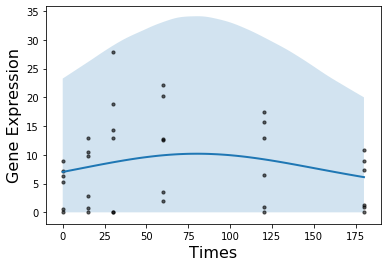

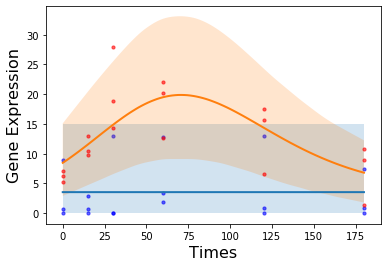

SPAC186.06


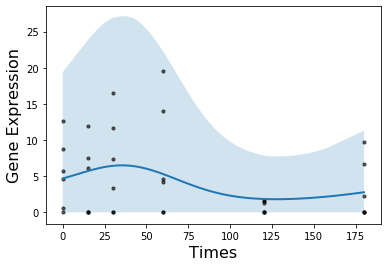

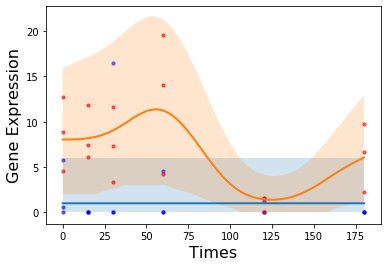

SPBC2A9.11c


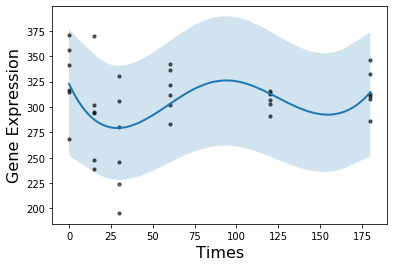

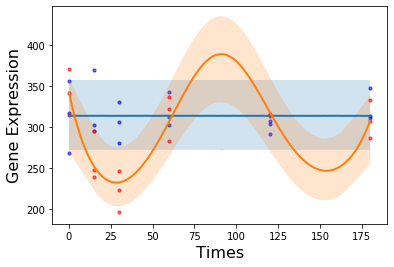

SPBC1271.07c


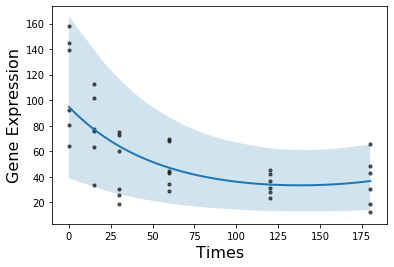

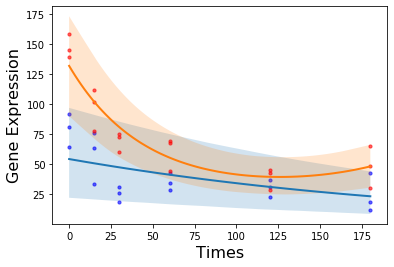

In [7]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot(likelihood,xtest,model,mean,var,count):
         
    plt.ylabel('Gene Expression', fontsize=16)
    plt.xlabel('Times', fontsize=16)
    
    if count == 1:
        c = 'black'

    elif count == 2:
        c = 'blue'

    else:
        c = 'red'
    
    xtest = np.linspace(np.min(model.data[0]),np.max(model.data[0]),100)[:,None] # points to make prediction
   
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]), alpha=0.2)
    else:
        lowess = sm.nonparametric.lowess
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = lowess(np.percentile(var, 95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,alpha = 0.2)
      
    plt.plot(xtest, mean, lw=2) 
    plt.scatter(model.data[0],model.data[1], s=10, color= c, alpha=0.6) #data

    if count == 1 or count ==3:
        plt.show()
        
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'Two_samples_test' # name of the test
xtest = np.linspace(np.min(X.values),np.max(X.values),100)[:,None] # points to make prediction
sample = True # sample or/and load model 
params = gp_counts.load_and_sample_models(indexes,test,xtest,likelihood,sample)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    count = 1
    for models,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        mean = np.array(mean)
        var = np.array(var)
        plot(likelihood,xtest,models,mean,var,count)
        count = count + 1

In [8]:
likelihood = 'Gaussian'
log_likelihood_ratio = gp_counts.Two_samples_test(likelihood)
log_likelihood_ratio

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPAC186.04c,-56.957426,-55.424281,-59.615716,-58.082571
SPAC186.06,-55.934383,-51.261039,-56.852431,-52.179087
SPBC2A9.11c,7.379950,-88.278626,-97.840265,-193.498842
SPBC1271.07c,-30.895298,-80.704737,-83.431345,-133.240784


SPAC186.04c


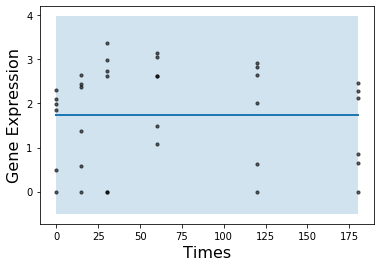

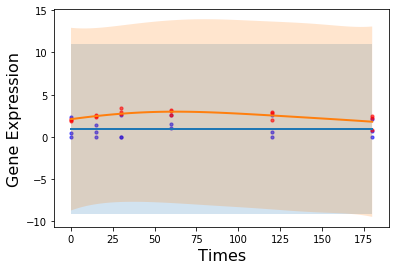

SPAC186.06


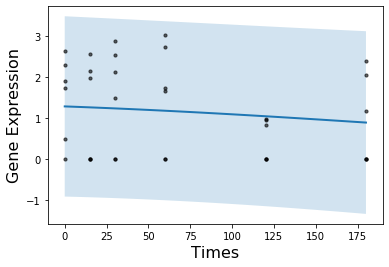

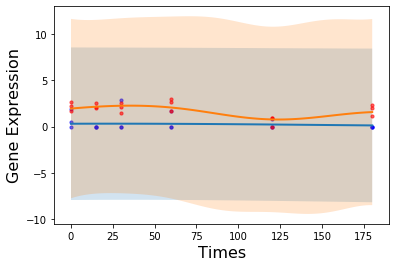

SPBC2A9.11c


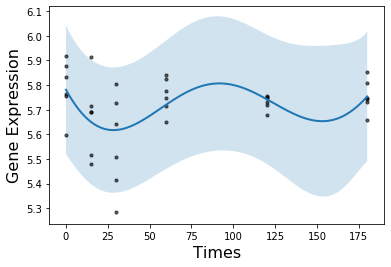

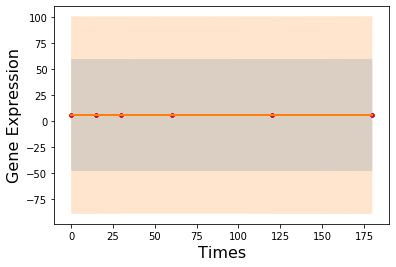

SPBC1271.07c


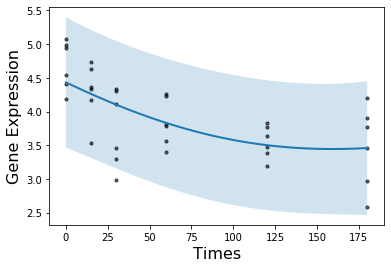

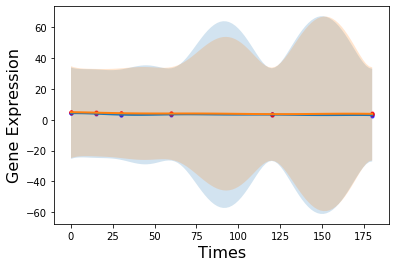

In [9]:
params = gp_counts.load_and_sample_models(indexes,test,xtest,likelihood,sample)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    count = 1
    for models,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        mean = np.array(mean)
        var = np.array(var)
        plot(likelihood,xtest,models,mean,var,count)
        count = count + 1